 <font color=orange size=5> 
iFood DA/DArq Case Solution / Éricka Caracas de Castro Santos
 </font>

In [129]:
# Importando bibliotecas e configurando o ambiente
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, current_date, datediff, when, avg, sum, col, count as pyspark_count, isnull, max, min, expr, round as ps_round, format_number, regexp_replace
from pyspark.sql import functions as F
from datetime import datetime
import matplotlib.pyplot as plt
import builtins 
import seaborn as sns
import requests
import os
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split, cross_val_predict
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [130]:
os.environ['JAVA_HOME'] = r"C:/Program Files/Java/jdk-11"
os.environ['SPARK_HOME'] = r"C:/Users/ericka/AppData/Roaming/Python/Python312/site-packages/pyspark"


In [131]:

# Inicializando uma sessão
spark = SparkSession.builder.appName("iFoodCase").getOrCreate()

<font color=orange size=6>Ingestão dos dados</font>


In [132]:
# Carregar o dataset de clientes a partir da URL do Github fornecida.
url = 'https://raw.githubusercontent.com/ifood/ifood-data-business-analyst-test/master/ml_project1_data.csv'
response = requests.get(url)

# Salvar o conteúdo do arquivo em um arquivo local temporário
with open('ml_project1_data.csv', 'wb') as f:
    f.write(response.content)

# Carregar o arquivo CSV 
data = spark.read.csv('ml_project1_data.csv', header=True, inferSchema=True)

# Total de registros e campos
num_registros = data.count()
num_colunas = len(data.columns)

# Exibir informações do schema, tipos de dados e total de campos e registros 
print("O dataset possui", num_registros, "registros distribuídos entre", num_colunas, "colunas.")

print("Colunas:", data.columns)

for column in data.columns:
    dtype = data.schema[column].dataType
    print(f"Campo: {column}, Tipo: {dtype}")


O dataset possui 2240 registros distribuídos entre 29 colunas.
Colunas: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
Campo: ID, Tipo: IntegerType()
Campo: Year_Birth, Tipo: IntegerType()
Campo: Education, Tipo: StringType()
Campo: Marital_Status, Tipo: StringType()
Campo: Income, Tipo: IntegerType()
Campo: Kidhome, Tipo: IntegerType()
Campo: Teenhome, Tipo: IntegerType()
Campo: Dt_Customer, Tipo: DateType()
Campo: Recency, Tipo: IntegerType()
Campo: MntWines, Tipo: IntegerType()
Campo: MntFruits, Tipo: IntegerType()
Campo: MntMeatProducts, Tipo: IntegerType()
Campo: MntFishProducts, Tipo: 

<font color=orange size=6>Tratamento dos dados</font>

In [133]:

# Renomeando as colunas
data_renamed = data.select(
    col("ID").alias("id_cliente"),
    col("Year_Birth").alias("ano_nascimento"),
    col("Education").alias("escolaridade"),
    col("Marital_Status").alias("estado_civil"),
    col("Income").alias("renda_anual"),
    col("Kidhome").alias("criancas"),
    col("Teenhome").alias("adolescentes"),
    col("Dt_Customer").alias("data_cadastro"),
    col("Recency").alias("recencia"),
    col("MntWines").alias("gasto_vinho"),
    col("MntFruits").alias("gasto_frutas"),
    col("MntMeatProducts").alias("gasto_carnes"),
    col("MntFishProducts").alias("gasto_peixe"),
    col("MntSweetProducts").alias("gasto_doces"),
    col("MntGoldProds").alias("gasto_gold"),
    col("NumDealsPurchases").alias("compras_desconto"),
    col("NumWebPurchases").alias("compras_web"),
    col("NumCatalogPurchases").alias("compras_catalogo"),
    col("NumStorePurchases").alias("compras_loja"),
    col("NumWebVisitsMonth").alias("visitas_web_mes"),
    col("AcceptedCmp1").alias("aceitou_cmp1"),
    col("AcceptedCmp2").alias("aceitou_cmp2"),
    col("AcceptedCmp3").alias("aceitou_cmp3"),
    col("AcceptedCmp4").alias("aceitou_cmp4"),
    col("AcceptedCmp5").alias("aceitou_cmp5"),
    col("Response").alias("resposta"),
    col("Complain").alias("reclamacao")
)


<font color=orange size=6>Análise Exploratória</font>


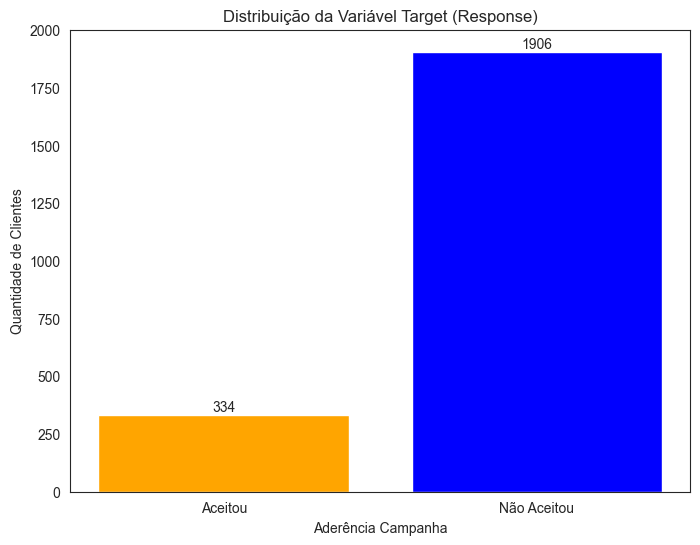

Proporção de clientes que aceitaram a última campanha: 15.00%
Proporção de clientes que não aceitaram a última campanha: 85.00%
Valor de aderência à campanha validado!


In [134]:
# Função para calcular a quantidade de clientes por valor em uma coluna
def calcular_qtde_clientes(data, column):
    # Contagem de valores na coluna
    qtde_clientes = data.groupBy(column).agg(F.count(column).alias("Quantidade"))
    return qtde_clientes

# Validar a proporção de clientes que aderiram ou não à última campanha (variável "Response")
qtde_response = calcular_qtde_clientes(data, 'Response')

# Calcular a proporção de clientes (percentual) diretamente no PySpark
total_clientes = data.count()

# Adicionar a coluna percentual ao DataFrame
qtde_response = qtde_response.withColumn(
    "percentual", F.round((F.col("Quantidade") / total_clientes) * 100)
)

# Coletar os dados do DataFrame para uso posterior
qtde_response_data = qtde_response.collect()


# Para plotar o gráfico:
responses = [row['Response'] for row in qtde_response_data]
quantities = [row['Quantidade'] for row in qtde_response_data]

# Configurações dos gráficos
plt.figure(figsize=(8, 6))
colors = ['orange', 'blue']
x_positions = range(len(qtde_response_data))

# Criando o gráfico de barras
plt.bar(x_positions, quantities, color=colors)
plt.title('Distribuição da Variável Target (Response)')
plt.xlabel('Aderência Campanha')
plt.ylabel('Quantidade de Clientes')

# Adicionar legendas com os valores
for i, count in enumerate(quantities):
    plt.text(i, count, f'{count}', ha='center', va='bottom')
    
response_labels = ["Aceitou", "Não Aceitou"]

plt.xticks(x_positions, response_labels)

# Garantir que as proporções sejam extraídas corretamente, independentemente da ordem
percentages_dict = {row['Response']: row['percentual'] for row in qtde_response_data}

# Exibir o gráfico
plt.show()

# Exibir as proporções com base nos valores '0' (não aceitou) e '1' (aceitou)
print(f"Proporção de clientes que aceitaram a última campanha: {percentages_dict.get(1, 0):.2f}%")
print(f"Proporção de clientes que não aceitaram a última campanha: {percentages_dict.get(0, 0):.2f}%")

print("Valor de aderência à campanha validado!")


<font color=purple size=5>Resultados de campanhas anteriores</font>


Resultados de aceitação dos clientes na campanha 1:
Aceitou: 6.43%
Não Aceitou: 93.57%
Resultados de aceitação dos clientes na campanha 2:
Aceitou: 1.34%
Não Aceitou: 98.66%
Resultados de aceitação dos clientes na campanha 3:
Aceitou: 7.28%
Não Aceitou: 92.72%
Resultados de aceitação dos clientes na campanha 4:
Aceitou: 7.46%
Não Aceitou: 92.54%
Resultados de aceitação dos clientes na campanha 5:
Aceitou: 7.28%
Não Aceitou: 92.72%


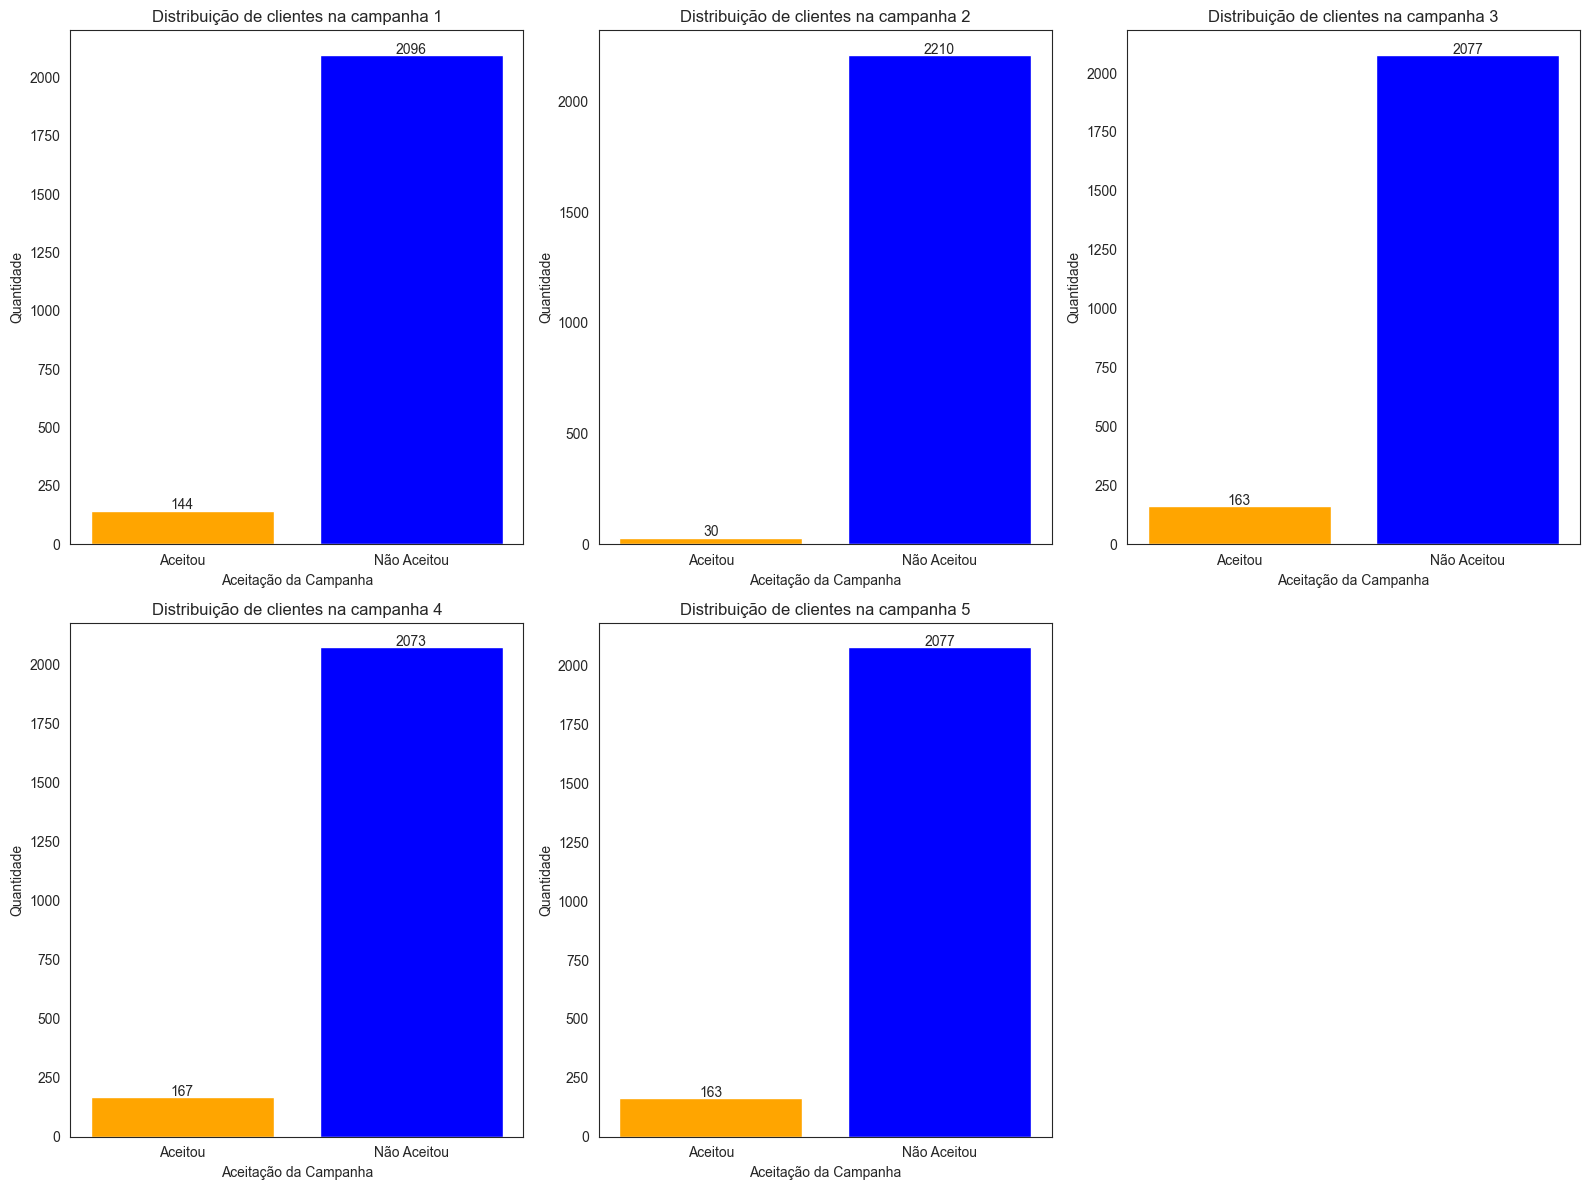

In [135]:
# Variáveis de aceitação das campanhas 1 à 5.
campaign_columns = ['aceitou_cmp1', 'aceitou_cmp2', 'aceitou_cmp3', 'aceitou_cmp4', 'aceitou_cmp5']
label_campaing = {0: 'Não Aceitou', 1: 'Aceitou'}

# Configurações dos gráficos
plt.figure(figsize=(16, 12))
palette = ['orange', 'blue']

for i, col_name in enumerate(campaign_columns, 1):
    campaign_name = col_name.replace("aceitou_cmp", "")
    counts = data_renamed.groupBy(col_name).agg(pyspark_count('*').alias('count')).collect()
    counts_dict = {label_campaing[row.asDict()[col_name]]: row['count'] for row in counts}

    # Exibir resultados
    print(f"Resultados de aceitação dos clientes na campanha {campaign_name}:")

    total = builtins.sum(counts_dict.values())

    for label, count_value in counts_dict.items():
        percentage = count_value / total * 100
        print(f"{label}: {percentage:.2f}%")

    # Gráfico
    plt.subplot(2, 3, i)
    plt.bar(counts_dict.keys(), counts_dict.values(), color=palette)
    plt.title(f'Distribuição de clientes na campanha {campaign_name}')
    plt.xlabel('Aceitação da Campanha')
    plt.ylabel('Quantidade')

    for j, (label, count_value) in enumerate(counts_dict.items()):
        plt.text(j, count_value + 5, f'{count_value}', ha='center')

plt.tight_layout()
plt.show()


<font color=black size=4>

- **_Dentre todas, a campanha 2 obteve a menor aderência com apenas 1,3% de aceitação para o total de 2.240 consumidores._**
- **_Mesmo com os resultados de aderência à última campanha(~15%) sendo o dobro das campanhas anteriores o retorno continua abaixo do esperado, portanto é necessário avaliar as variáveis da base de consumidores e traçar seus perfis para uma taxa de sucesso maior nas próximas campanhas._**

</font>

**<font color=purple size=6>Segmentação da base de clientes</font>**


<font color=purple size=5>Análise RFM (Recência, Frequência e Valor Monetário) </font>


        ID  Recency  Frequency  Monetary
15    2114       23          3      1315
60    6853       12          3      1438
67    9369       19          3      1274
135   1685       21          1      1482
141  11084        4          1      1053


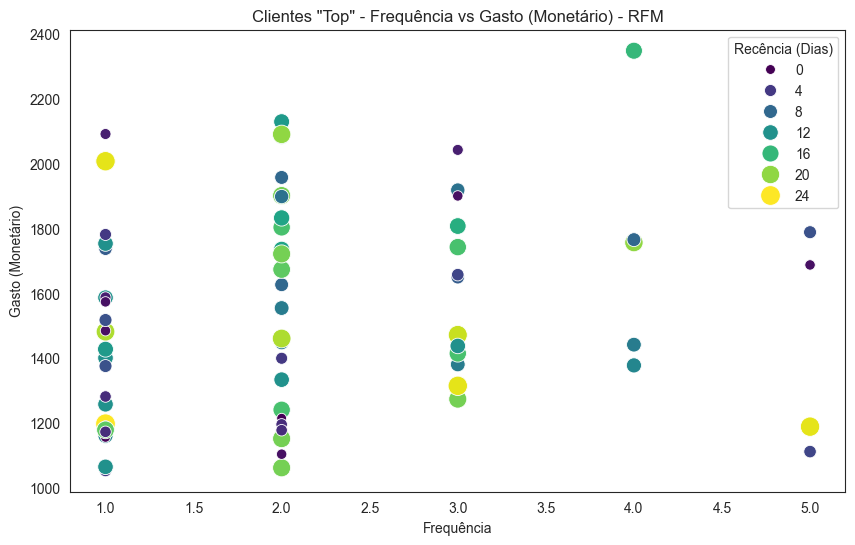

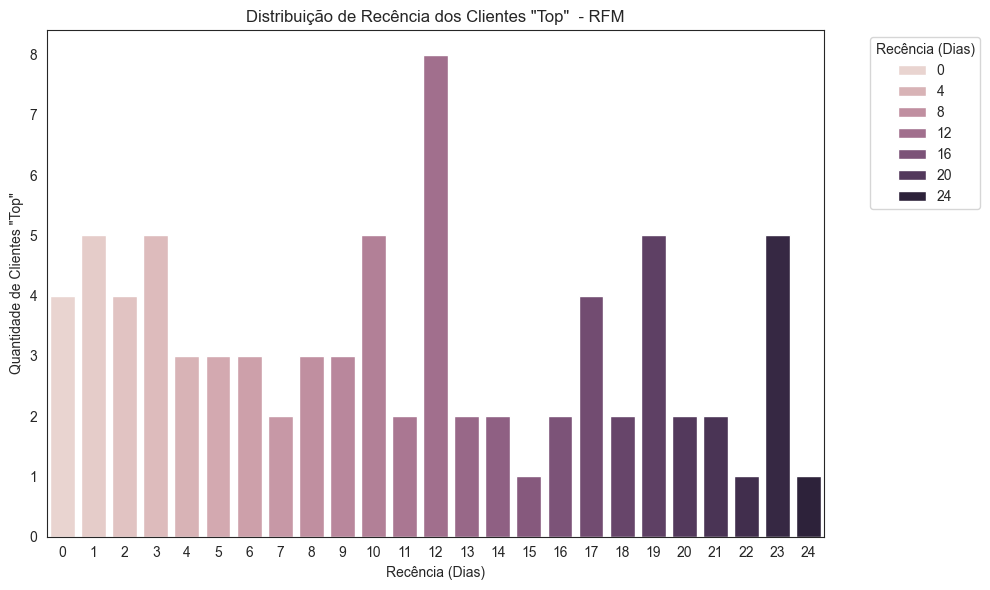

In [136]:
# Importação no Pandas da base de dados para criação de gráficos de dispersão
data = pd.read_csv(url)

# Variável Recência (R): dias desde a última compra do cliente
data['Recency'] =  data['Recency']

# Cálculo da variável Frequência (F): soma das aceitação em pelo menos uma campanha, incluindo a campanha piloto
data['Frequency'] = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']].sum(axis=1)

# Cálculo Valor Monetário (M): total de gastos com produtos de todas as categorias
data['Monetary'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds']].sum(axis=1)

# Colunas para análise RFM
rfm_data = data[['ID', 'Recency', 'Frequency', 'Monetary']]

# Exibição de exemplos de id_cliente com um frequência boa, poucos dias desde a última compra e alto valor em gastos
rfm_data.head()

# Definir limiares de recência, frequência e gasto (com base nos quantis)
recency_threshold = data['Recency'].quantile(0.25)  # Clientes mais recentes (quantil inferior)
frequency_threshold = data['Frequency'].quantile(0.75)  # Clientes mais frequentes (quantil superior)
monetary_threshold = data['Monetary'].quantile(0.75)  # Clientes de maior gasto (quantil superior)

# Filtrando os clientes "Top"
clientes_top = data[(data['Recency'] <= recency_threshold) & 
                    (data['Frequency'] >= frequency_threshold) & 
                    (data['Monetary'] >= monetary_threshold)]

# Exibir os primeiros clientes "Top"
print(clientes_top[['ID', 'Recency', 'Frequency', 'Monetary']].head())

# Criar um gráfico de dispersão para visualizar a relação entre Recency, Frequency e Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=clientes_top, hue='Recency', palette='viridis', size='Recency', sizes=(50, 200))
plt.title('Clientes "Top" - Frequência vs Gasto (Monetário) - RFM')
plt.xlabel('Frequência')
plt.ylabel('Gasto (Monetário)')
plt.legend(title='Recência (Dias)')
plt.show()


# Exibição do gráfico da quantidade de clientes "Top" com recência baixa
plt.figure(figsize=(10, 6))
sns.countplot(data=clientes_top, x='Recency', hue='Recency')

# Configurar gráfico
plt.title('Distribuição de Recência dos Clientes "Top"  - RFM')
plt.xlabel('Recência (Dias)')
plt.ylabel('Quantidade de Clientes "Top"')
plt.legend(title='Recência (Dias)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()   
plt.show()


RFM_Segment
Antigo-Infrequente-Baixo     1050
Recente-Infrequente-Baixo     323
Antigo-Frequente-Alto         223
Antigo-Infrequente-Alto       205
Antigo-Frequente-Baixo        195
Recente-Frequente-Baixo       112
Recente-Frequente-Alto         79
Recente-Infrequente-Alto       53
Name: count, dtype: int64


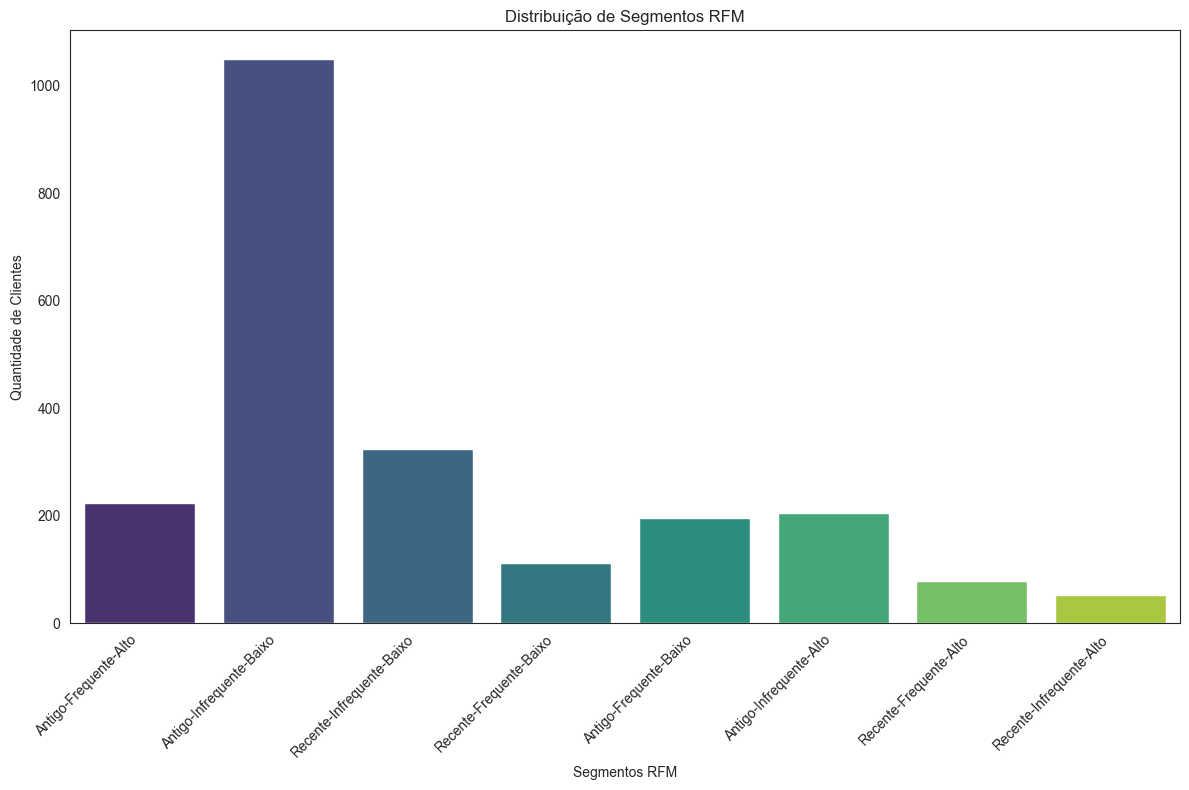

     ID  Recency  Frequency  Monetary                RFM_Segment
0  5524       58          1      1617      Antigo-Frequente-Alto
1  2174       38          0        27   Antigo-Infrequente-Baixo
2  4141       26          0       776   Antigo-Infrequente-Baixo
3  6182       26          0        53   Antigo-Infrequente-Baixo
4  5324       94          0       422   Antigo-Infrequente-Baixo
5  7446       16          0       716  Recente-Infrequente-Baixo
6   965       34          0       590   Antigo-Infrequente-Baixo
7  6177       32          0       169   Antigo-Infrequente-Baixo
8  4855       19          1        46    Recente-Frequente-Baixo
9  5899       68          1        49     Antigo-Frequente-Baixo


In [137]:
# Função para categorizar os clientes em segmentos RFM
def rfm_segment(row):
    if row['Recency'] <= recency_threshold:
        recency = 'Recente'
    else:
        recency = 'Antigo'

    if row['Frequency'] >= frequency_threshold:
        frequency = 'Frequente'
    else:
        frequency = 'Infrequente'
    
    if row['Monetary'] >= monetary_threshold:
        monetary = 'Alto'
    else:
        monetary = 'Baixo'
    
    return f'{recency}-{frequency}-{monetary}'

# Aplicar a função e criar a coluna de segmentos RFM
data['RFM_Segment'] = data.apply(rfm_segment, axis=1)

print(data['RFM_Segment'].value_counts())

# Gráfico 
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='RFM_Segment', hue='RFM_Segment', legend=False, palette='viridis')
plt.title('Distribuição de Segmentos RFM')
plt.xlabel('Segmentos RFM')
plt.ylabel('Quantidade de Clientes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Exibir os primeiros 10 registros da tabela com os segmentos RFM
print(data[['ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Segment']].head(10))


<font color=black size=4>

* **_A análise de RFM(Recência, Frequência e Valor Monetário) auxilia na identificação dos clientes mais valiosos, ou seja, aqueles com alta frequência, alto gasto e recência recente._**

* **_Para próximas campanhas esses clientes devem ser o foco principal de estratégias de marketing e ações de fidelização, enquanto estratégias de reengajamento podem ser aplicadas para os clientes com recência mais alta._** 

* **_As visualizações acima ajudam a entender a distribuição desses clientes, e as decisões estratégicas podem ser feitas com base nesses insights para melhorar os resultados de vendas e retenção de clientes. Por exemplo, temos 51% dos clientes classificados como antigos, infrequentes e baixos, que representa os clientes que não compraram recentemente, compram raramente e gastam pouco, sendo classificados como clientes em risco de abandono._** 
* **_Campanhas de reengajamento ou ofertas de descontos podem ser uma boa estratégia para atrair esses clientes de volta, apesar do baixo valor monetário de gastos, a sua representativade em relação ao todo é significativa e seu perfil deve ser considerado em futuras campanhas._**

<font color=purple size=6>Análise de Perfil Cliente - Produtos, Faixa Etária, Escolaridade e Estado Civil</font>


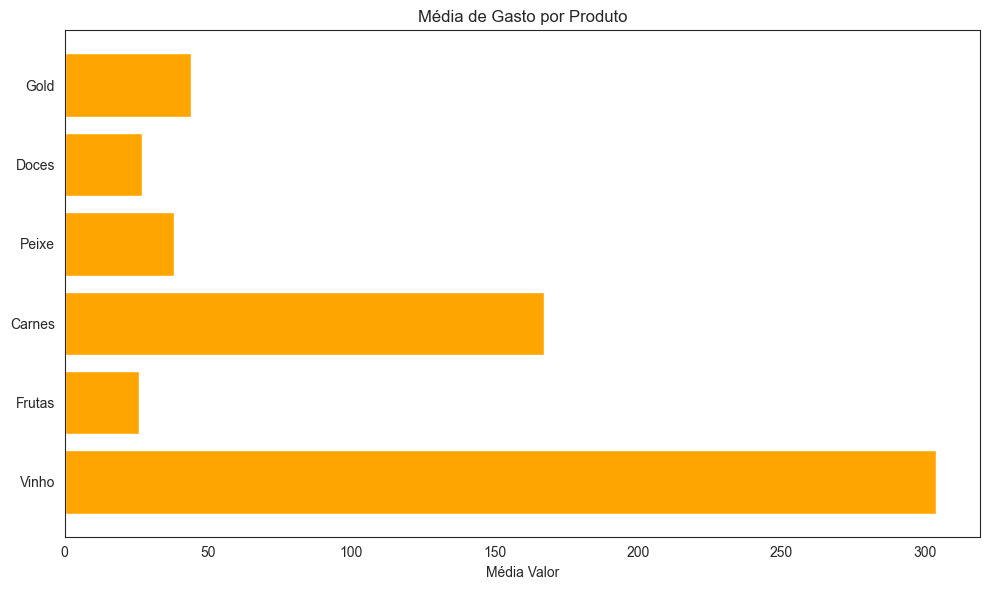

In [138]:
# Análise - Gasto total e média com produtos
gasto_produtos = data_renamed.select(
    F.sum("gasto_vinho").alias("total_gasto_vinho"),
    F.round(avg("gasto_vinho"),0).alias("media_gasto_vinho"),
    F.sum("gasto_frutas").alias("total_gasto_frutas"),
    F.round(avg("gasto_frutas"),0).alias("media_gasto_frutas"),
    F.sum("gasto_carnes").alias("total_gasto_carnes"),
    F.round(avg("gasto_carnes"),0).alias("media_gasto_carnes"),
    F.sum("gasto_peixe").alias("total_gasto_peixe"),
    F.round(avg("gasto_peixe"),0).alias("media_gasto_peixe"),
    F.sum("gasto_doces").alias("total_gasto_doces"),
    F.round(avg("gasto_doces"),0).alias("media_gasto_doces"),
    F.sum("gasto_gold").alias("total_gasto_gold"),
    F.round(avg("gasto_gold"),0).alias("media_gasto_gold"),
)

# Produtos  
gasto_produtos_data = gasto_produtos.collect()[0]
produtos = ['Vinho', 'Frutas', 'Carnes', 'Peixe', 'Doces', 'Gold']

# Média de gasto
media_gasto = [
    gasto_produtos_data['media_gasto_vinho'],
    gasto_produtos_data['media_gasto_frutas'],
    gasto_produtos_data['media_gasto_carnes'],
    gasto_produtos_data['media_gasto_peixe'],
    gasto_produtos_data['media_gasto_doces'],
    gasto_produtos_data['media_gasto_gold']
]

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(produtos, media_gasto, color='orange')
ax.set_xlabel('Média Valor')
ax.set_title('Média de Gasto por Produto')

# Gráfico
plt.tight_layout()
plt.show()

In [139]:
# Tratamento dos valores nulos do campo "Income" e preenchimento com um valor padrão.
data = data.fillna({'Income': 0})

#  Análise - Total de compras por canal e visitas ao site
compras_canal = data_renamed.select(
    sum("compras_web").alias("total_compras_web"),
    sum("compras_catalogo").alias("total_compras_catalogo"),
    sum("compras_loja").alias("total_compras_loja")
)

# Calculando a idade do cliente
data_renamed = data_renamed.withColumn("Age", year(current_date()) - col("ano_nascimento"))

# Criando Faixas Etárias
data_renamed = data_renamed.withColumn("faixa_etaria",
                       when(data_renamed.Age < 20, "Menor que 20 anos")
                       .when((data_renamed.Age >= 20) & (data_renamed.Age < 36), "Entre 20-35 anos")
                       .when((data_renamed.Age >= 36) & (data_renamed.Age < 46), "Entre 36-45 anos")
                       .when((data_renamed.Age > 45)  & (data_renamed.Age < 51), "Entre 46-50 anos")
                       .when((data_renamed.Age >= 51) & (data_renamed.Age < 67), "Entre 51-66 anos")
                       .otherwise("Maior que 66 anos"))

# Calcular a quantidade de clientes por faixa etária
qtde_faixa_etaria = data_renamed.groupBy("faixa_etaria").agg(F.count("id_cliente").alias("quantidade"))
total_clientes = data_renamed.count()   

# Análise - Perfil demográfico por educação e estado civil
escolaridade_estado_civil = data_renamed.groupBy("estado_civil", "escolaridade").count().withColumnRenamed("count", "total").orderBy("total", ascending=False)


# Exibir resultados
compras_canal.show()
escolaridade_estado_civil.show()

+-----------------+----------------------+------------------+
|total_compras_web|total_compras_catalogo|total_compras_loja|
+-----------------+----------------------+------------------+
|             9150|                  5963|             12970|
+-----------------+----------------------+------------------+

+------------+------------+-----+
|estado_civil|escolaridade|total|
+------------+------------+-----+
|     Married|  Graduation|  433|
|    Together|  Graduation|  286|
|      Single|  Graduation|  252|
|     Married|         PhD|  192|
|     Married|      Master|  138|
|    Divorced|  Graduation|  119|
|    Together|         PhD|  117|
|    Together|      Master|  106|
|      Single|         PhD|   98|
|     Married|    2n Cycle|   81|
|      Single|      Master|   75|
|    Together|    2n Cycle|   57|
|    Divorced|         PhD|   52|
|    Divorced|      Master|   37|
|      Single|    2n Cycle|   37|
|       Widow|  Graduation|   35|
|       Widow|         PhD|   24|
|    Divo

<font color=purple size=5>Faixa Etária por Aceitação à Campanha</font>


In [140]:

# Calcular a quantidade de clientes por faixa etária
qtde_faixa_etaria = data_renamed.groupBy("faixa_etaria").agg(
    F.count("id_cliente").alias("total")
)

# Calcular a soma da renda anual por faixa etária
renda_faixa_etaria = data_renamed.groupBy("faixa_etaria").agg(
    F.regexp_replace(
        F.format_number(F.round(F.sum("renda_anual"), 0), 0), 
        ",", "."
    ).alias("total_renda_anual")
)

# Combinar as duas tabelas
renda_faixa_etaria = renda_faixa_etaria.join(qtde_faixa_etaria, on="faixa_etaria", how="inner")

# Calcular a representação percentual
total_clientes = data_renamed.count()
renda_faixa_etaria = renda_faixa_etaria.withColumn(
    "representação(%)", F.round((F.col("total") / total_clientes) * 100, 0)  
)

# Ordenar pela representação percentual
renda_faixa_etaria = renda_faixa_etaria.orderBy("faixa_etaria", ascending=True)

renda_faixa_etaria = renda_faixa_etaria.select(
    "faixa_etaria",
    "total",
    "representação(%)",
    "total_renda_anual"
)

# Exibindo o DataFrame reorganizado
renda_faixa_etaria.show()


+-----------------+-----+----------------+-----------------+
|     faixa_etaria|total|representação(%)|total_renda_anual|
+-----------------+-----+----------------+-----------------+
| Entre 20-35 anos|   61|             3.0|        3.225.497|
| Entre 36-45 anos|  363|            16.0|       16.415.257|
| Entre 46-50 anos|  354|            16.0|       17.719.211|
| Entre 51-66 anos|  943|            42.0|       48.643.586|
|Maior que 66 anos|  519|            23.0|       29.776.358|
+-----------------+-----+----------------+-----------------+



<font color=black size=4>

* **_Com os resultados acima identificamos que os clientes entre 36 e 66 anos representam 74% dos consumidores selecionados para a campanha, sendo 42% na faixa etária entre 51 e 66 anos com maior renda anual._**
* **_Outro ponto que vale ressaltar é a ausência de consumidores mais jovens, com menos que 20 anos._**
</font>


<font color=black size=4>

* **_Temos uma base com clientes que gastaram mais em vinhos, geralmente são casados ou moram juntos, possuem uma graduação, preferem comprar na loja e estão na faixa etária entre 51 e 66 anos._**
* **_Para a próxima campanha direcione ofertas de vinhos premium nesse perfil para ter uma aderência maior._**

</font>

<font color=purple size=5>Dias da última compra por Aceitação à Campanha</font>


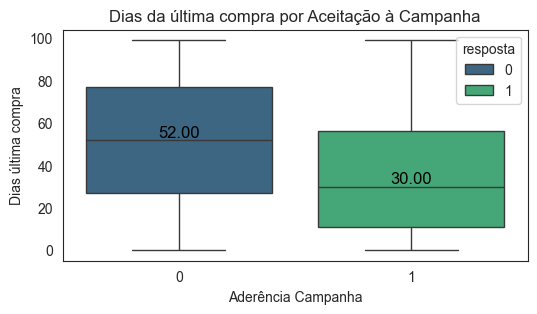

In [141]:

# Análise - Perfil por resposta e recência
aceite_recencia = data_renamed.withColumn(
    "resposta",
    F.when(F.col("resposta") == 1, "Aceitou")
     .when(F.col("resposta") == 0, "Não Aceitou")
     .otherwise(F.col("resposta"))
)


# Converter o DataFrame PySpark para Pandas com a finalidade de criar o gráfico compatível
data_renamed_pandas = data_renamed.toPandas()

# Configurando gráfico
sns.set_style("white")
plt.figure(figsize=(6, 3))
sns.boxplot(data=data_renamed_pandas, x='resposta', y='recencia', palette="viridis", hue='resposta')

for i, box in enumerate(data_renamed_pandas.groupby('resposta')['recencia'].median()):
    plt.text(i, box, f'{box:.2f}', ha='center', va='bottom', fontsize=12, color='black')

plt.grid(False)
plt.title('Dias da última compra por Aceitação à Campanha')
plt.xlabel('Aderência Campanha')
plt.ylabel('Dias última compra')

plt.show()


<font color=black size=4>

* **_Em relação à quantidade de dias da última compra, clientes que efeturam o último pedido na média de 30 dias tiveram maior aceitação à campanha em comparação com consumidores que estavam a mais de 50 dias sem realizar uma compra._** 
* **_Considerando os pontos citados anteriormente, clientes que realizam compras na loja podem ter visualizado alguma oferta e retornado para aderir a campanha atual._**
</font>

<font color=purple size=5>Média de gastos com vinhos por Aceitação à Campanha</font>


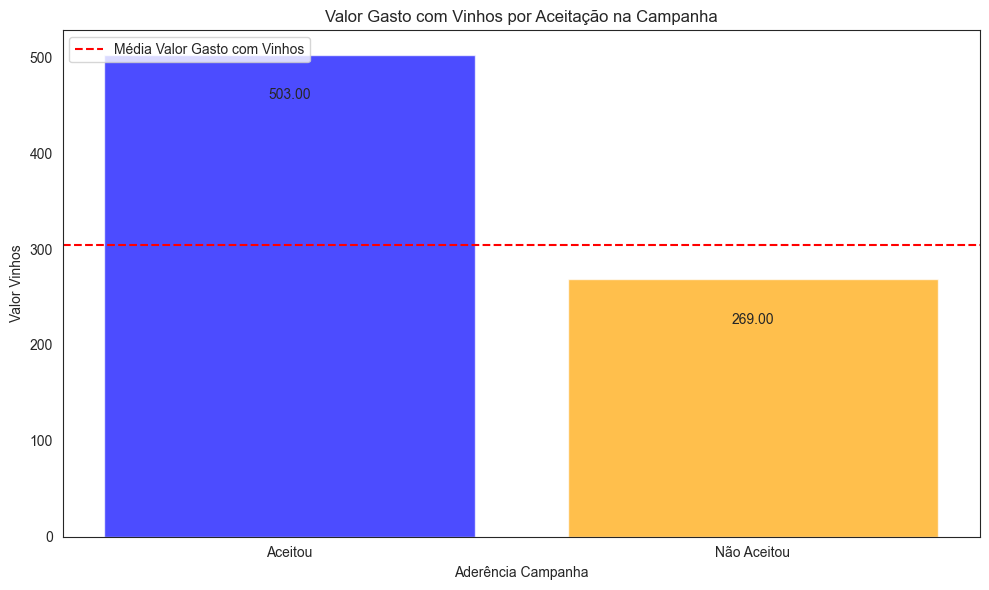

In [142]:
# Representação gráfica dos resultados de aceitação da última campanha de acordo com a média de gastos com vinhos
data_renamed = data_renamed.withColumn(
    "resposta",
    F.when(F.col("resposta") == 1, "Aceitou")
     .when(F.col("resposta") == 0, "Não Aceitou")
     .otherwise(F.col("resposta"))
)

# Calcular a média de gasto com vinhos por resposta
avg_gasto_vinho = data_renamed.groupBy('resposta').agg(
    F.round(F.avg('gasto_vinho')).alias('avg_gasto_vinho')
)

# Converter para Pandas DataFrame  
df_avg_gasto_vinho = avg_gasto_vinho.toPandas()

# Configurações do gráfico
sns.set_style("white")
plt.figure(figsize=(10, 6))
bar_colors = ['blue', 'orange']

# Criar gráfico de barras
bars = plt.bar(
    df_avg_gasto_vinho['resposta'], 
    df_avg_gasto_vinho['avg_gasto_vinho'], 
    color=bar_colors, 
    alpha=0.7
)

# Adicionar valores no topo das barras
for i, row in df_avg_gasto_vinho.iterrows():
    plt.text(i, row['avg_gasto_vinho'] - 50, f'{row["avg_gasto_vinho"]:.2f}', ha='center', va='bottom')

avg_total_gasto_vinho = data_renamed.select(F.avg('gasto_vinho')).collect()[0][0]
plt.axhline(y=avg_total_gasto_vinho, color='red', linestyle='--', label='Média Valor Gasto com Vinhos')

# Configurar título e rótulos
plt.title('Valor Gasto com Vinhos por Aceitação na Campanha')
plt.xlabel('Aderência Campanha')
plt.ylabel('Valor Vinhos')
plt.xticks(['Aceitou','Não Aceitou'])
plt.legend(loc='upper left')

# Exibir gráfico
plt.tight_layout()
plt.show()


<font color=black size=4>

- **_Analisando a média de gastos com vinho confirma-se que os consumidores que aderiram à última campanha, dentre todos os produtos, tiveram um gasto maior com vinhos nos últimos dois anos._**
- **_A alta aderência de consumidores nesse perfil pode ter sido originada por ofertas de vinhos mais caros na campanha, resultando na aquisição por clientes que já possuem esse perfil de compra._**
</font>

<font color=orange size=6>Modelo preditivo de classificação </font>

Acurácia do modelo: 85 %


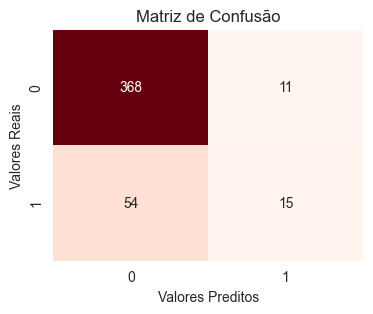

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       379
           1       0.58      0.22      0.32        69

    accuracy                           0.85       448
   macro avg       0.72      0.59      0.62       448
weighted avg       0.83      0.85      0.83       448



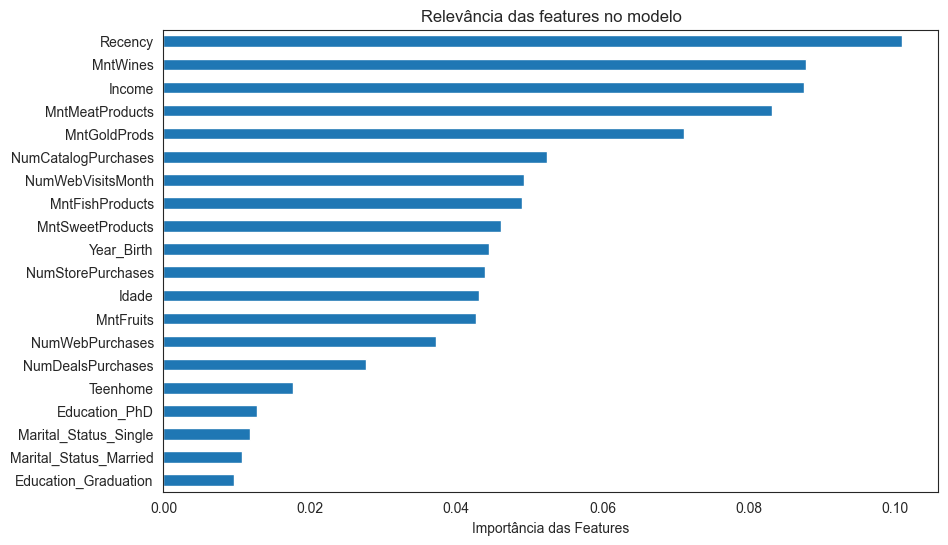

In [143]:

# Para o treino e modelagem utilizei a base de dados 'raw', sem os tratamentos anteriores realizados na análise exploratória. 

# Importação no Pandas da base de dados
data = pd.read_csv(url)

# Tratamento do tipo do campo "Income" e preenchimento dos valores nulos com um valor padrão.
data['Income'] = data['Income'].fillna(0).astype('int64')


def calcular_idade(ano_nascimento):
    ano_corrente = datetime.now().year
    idade = ano_corrente - ano_nascimento
    return idade

data['Idade'] = data['Year_Birth'].apply(calcular_idade)

# Criando Faixas Etárias
data['faixa_etaria'] = np.select(
    [
        data['Idade'] < 20,
        (data['Idade'] >= 20) & (data['Idade'] < 36),
        (data['Idade'] >= 36) & (data['Idade'] < 46),
        (data['Idade'] >= 46) & (data['Idade'] < 56),
        (data['Idade'] >= 56) & (data['Idade'] < 66),
        data['Idade'] >= 66
    ],
    [
        'Menor que 20 anos', 
        'Entre 20-35 anos', 
        'Entre 36-45 anos', 
        'Entre 46-55 anos', 
        'Entre 56-65 anos', 
        'Maior que 66 anos'
    ],
    default='Idade não informada'
)

# Pré-processamento das variáveis categóricas
data = pd.get_dummies(data, columns=['Education', 'Marital_Status', 'faixa_etaria'])

# Separar features e target
X = data.drop(['ID', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Response','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2'], axis=1) 
y = data['Response']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo 
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) 
accuracy_percent = builtins.round(accuracy * 100)
print("Acurácia do modelo:", accuracy_percent, "%")


# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds', cbar=False)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Analisar a importância das variáveis no modelo
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Visualizar as 20 características mais importantes
plt.figure(figsize=(10, 6))
feature_importances_sorted[:20].sort_values().plot(kind='barh')
plt.xlabel('Importância das Features')
plt.title('Relevância das features no modelo')
plt.show()

# Finalizar a sessão 
spark.stop()

<font color=black size=5>

# Sobre o modelo

* **_Apesar do bom percentual da acurácia para o modelo (85%), verificamos que o recall está bem baixo, com 22%, o que representa que da base total menos da metade dos clientes realmente são o público alvo e aceitariam a campanha._** 

* **_Para evitar futuras ações de marketing com o mesmo resultado é importante considerar as características dos perfis comportamentais e de compras dos  clientes, sempre considerando sua representatividade no total, e realizar campanhas focadas nesse perfis traçados para termos uma taxa de adesão precisa, maior e sem tanto risco de atingir somente nichos específicos com pouca representatividade e retorno._** 
</font>


<font color=purple size=5>

# Conclusão

* Em análise da importância das variáveis no modelo temos alguns exemplos como dias da última compra('Recency') e média do valor gasto com 
vinhos ('MntWines) no topo. 
* Conforme apresentado na análise exploratória das variáveis, clientes que realizaram compras nos últimos 30 dias, possuem renda alta e  que tiveram gastos com vinhos mais caros nos últimos anos tiveram uma tendência maior a aceitar a campanha, o que justifica a relevância das features no modelo.
* A idade, apesar de não ser uma característica tão relevante dentre as features do modelo é uma métrica importante já que somente em uma única faixa etária (Entre 51-66 anos) temos a representativade de 42% da base total de clientes.
</font>